In [1]:
#%pip install psycopg2
#%pip install imblearn
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE

In [2]:
# Connection parameters
hostname = 'localhost'
database = 'postgres'
username = 'postgres'
password = 'admin'
port = 5433

# Establish connection
conn = psycopg2.connect(host=hostname, database=database, user=username, password=password, port = port)

In [3]:
cur = conn.cursor()

In [4]:
# Define la consulta SQL
sql_query = "SELECT * FROM public.fraudes"

# Crea el DataFrame usando la consulta SQL y la conexión
df = pd.read_sql_query(sql_query, conn)

F:\Users\usuario\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [5]:
df.head()

,monthh,weekofmonth,dayofweek,make,accidentarea,dayofweekclaimed,monthclaimed,weekofmonthclaimed,sex,maritalstatus,...,ageofvehicle,ageofpolicyholder,policereportfiled,witnesspresent,agenttype,numberofsuppliments,addresschange_claim,numberofcars,yearr,basepolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [6]:
df.describe()

,weekofmonth,weekofmonthclaimed,age,fraudfound_p,policynumber,repnumber,deductible,driverrating,yearr
count,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,2.788586,2.693969,39.855707,0.059857,7710.500000,8.483268,407.704280,2.487808,1994.866472
std,1.287585,1.259115,13.492377,0.237230,4451.514911,4.599948,43.950998,1.119453,0.803313
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,300.000000,1.000000,1994.000000
25%,2.000000,2.000000,31.000000,0.000000,3855.750000,5.000000,400.000000,1.000000,1994.000000
50%,3.000000,3.000000,38.000000,0.000000,7710.500000,8.000000,400.000000,2.000000,1995.000000
75%,4.000000,4.000000,48.000000,0.000000,11565.250000,12.000000,400.000000,3.000000,1996.000000
max,5.000000,5.000000,80.000000,1.000000,15420.000000,16.000000,700.000000,4.000000,1996.000000


#### Se transforman las variables categóricas con formato de texto a formato numérico para facilitar el análisis.

In [7]:
# Se mapea la variable dayofweek a una variable numérica
dias_semana = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

# Aplicar mapeo a la columna 'DayOfWeek'
df['dayofweek'] = df['dayofweek'].map(dias_semana)

# Se mapea la variable AccidentArea para que sea numérica
dias_semana = {
    'Urban': 1,
    'Rural': 2,
}

# Aplicar mapeo a la columna 'AccidentArea'
df['accidentarea'] = df['accidentarea'].map(dias_semana)

# Aplicar mapeo a la columna 'Sex'
sexo= {
    'Male': 1,
    'Female': 2,
}

# Aplicar mapeo a la columna 'Sex'
df['sex'] = df['sex'].map(sexo)

# Aplicar mapeo a la columna 'WitnessPresent'
witness= {
    'No': 1,
    'Yes': 2,
}

# Aplicar mapeo a la columna 'Sex'
df['witnesspresent'] = df['witnesspresent'].map(witness)

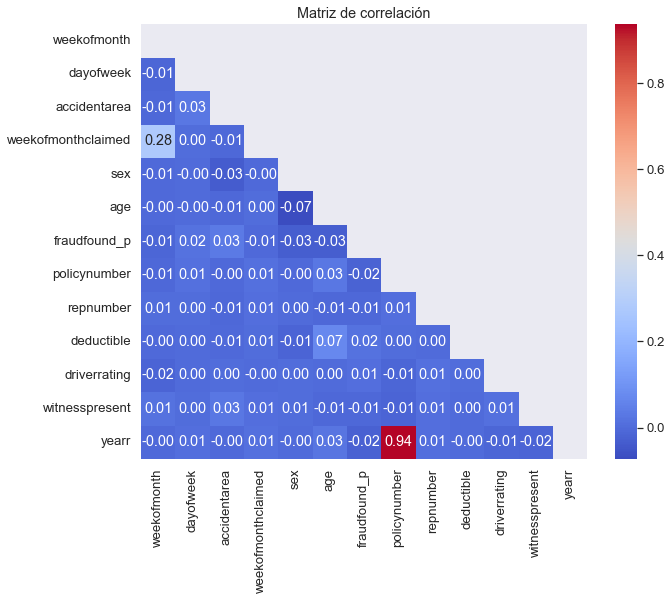

In [8]:
# Calcula la matriz de correlación
correlation_matrix = df.corr()

# Genera una máscara para el triángulo superior
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Configura el estilo de la figura
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)

# Grafica la matriz de correlación
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# Configura el título del gráfico
plt.title("Matriz de correlación")

# Muestra el gráfico
plt.show()

In [9]:
df.describe()

,weekofmonth,dayofweek,accidentarea,weekofmonthclaimed,sex,age,fraudfound_p,policynumber,repnumber,deductible,driverrating,witnesspresent,yearr
count,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,2.788586,3.807847,1.103632,2.693969,1.156939,39.855707,0.059857,7710.500000,8.483268,407.704280,2.487808,1.005642,1994.866472
std,1.287585,1.979394,0.304792,1.259115,0.363755,13.492377,0.237230,4451.514911,4.599948,43.950998,1.119453,0.074904,0.803313
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,300.000000,1.000000,1.000000,1994.000000
25%,2.000000,2.000000,1.000000,2.000000,1.000000,31.000000,0.000000,3855.750000,5.000000,400.000000,1.000000,1.000000,1994.000000
50%,3.000000,4.000000,1.000000,3.000000,1.000000,38.000000,0.000000,7710.500000,8.000000,400.000000,2.000000,1.000000,1995.000000
75%,4.000000,5.000000,1.000000,4.000000,1.000000,48.000000,0.000000,11565.250000,12.000000,400.000000,3.000000,1.000000,1996.000000
max,5.000000,7.000000,2.000000,5.000000,2.000000,80.000000,1.000000,15420.000000,16.000000,700.000000,4.000000,2.000000,1996.000000


#### Se evidencia que hay reportes de personas con una edad de 0, adicionalmente, la única correlación notable se da entre policynumber y age, aunque policynumber solo indica el número de columna.



#### Teniendo esto en cuenta, se suprime la columna policynumber y se suprimen los registros de age = 0

In [10]:
df.loc[df['age'] == 0]
df = df.loc[df['age'] != 0]
df = df.drop('policynumber', axis=1)

In [25]:
df.describe()

,weekofmonth,dayofweek,accidentarea,weekofmonthclaimed,sex,age,fraudfound_p,repnumber,deductible,driverrating,witnesspresent,yearr
count,15100.000000,15100.000000,15100.000000,15100.000000,15100.000000,15100.000000,15100.000000,15100.000000,15100.000000,15100.000000,15100.000000,15100.000000
mean,2.791126,3.810530,1.102384,2.694371,1.160265,40.700331,0.059073,8.479669,407.874172,2.488212,1.005629,1994.869272
std,1.287610,1.978407,0.303163,1.259930,0.366864,12.309493,0.235769,4.600028,44.391196,1.120435,0.074819,0.803246
min,1.000000,1.000000,1.000000,1.000000,1.000000,16.000000,0.000000,1.000000,300.000000,1.000000,1.000000,1994.000000
25%,2.000000,2.000000,1.000000,2.000000,1.000000,31.000000,0.000000,5.000000,400.000000,1.000000,1.000000,1994.000000
50%,3.000000,4.000000,1.000000,3.000000,1.000000,39.000000,0.000000,8.000000,400.000000,2.000000,1.000000,1995.000000
75%,4.000000,5.000000,1.000000,4.000000,1.000000,49.000000,0.000000,12.000000,400.000000,3.000000,1.000000,1996.000000
max,5.000000,7.000000,2.000000,5.000000,2.000000,80.000000,1.000000,16.000000,700.000000,4.000000,2.000000,1996.000000


#### Se elimina un total de 333 registros que no contaban con una edad asignada para el reporte. Esto equivale al 2.15% del total del df, por lo que no es un grupo muy grande el que se suprime. En la descripción se puede observar que el promedio de registros que son fraude no cambia demasiado.

In [11]:
#Descripción de los datos cuando se registra fraude
df.loc[df['fraudfound_p'] == 1].describe()

,weekofmonth,dayofweek,accidentarea,weekofmonthclaimed,sex,age,fraudfound_p,repnumber,deductible,driverrating,witnesspresent,yearr
count,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.0,892.000000,892.000000,892.000000,892.000000,892.000000
mean,2.733184,3.933857,1.146861,2.664798,1.117713,39.595291,1.0,8.354260,411.098655,2.516816,1.003363,1994.811659
std,1.273267,2.039205,0.354166,1.257424,0.322449,12.099424,0.0,4.526274,47.379398,1.121541,0.057928,0.793038
min,1.000000,1.000000,1.000000,1.000000,1.000000,16.000000,1.0,1.000000,300.000000,1.000000,1.000000,1994.000000
25%,2.000000,2.000000,1.000000,2.000000,1.000000,31.000000,1.0,5.000000,400.000000,1.000000,1.000000,1994.000000
50%,3.000000,4.000000,1.000000,3.000000,1.000000,37.000000,1.0,8.000000,400.000000,3.000000,1.000000,1995.000000
75%,4.000000,6.000000,1.000000,4.000000,1.000000,46.000000,1.0,12.000000,400.000000,4.000000,1.000000,1995.000000
max,5.000000,7.000000,2.000000,5.000000,2.000000,80.000000,1.0,16.000000,700.000000,4.000000,2.000000,1996.000000


In [12]:
#Descripción de los datos cuando NO se registra fraude
df.loc[df['fraudfound_p'] == 0].describe()

,weekofmonth,dayofweek,accidentarea,weekofmonthclaimed,sex,age,fraudfound_p,repnumber,deductible,driverrating,witnesspresent,yearr
count,14208.000000,14208.000000,14208.000000,14208.000000,14208.000000,14208.000000,14208.0,14208.000000,14208.000000,14208.000000,14208.000000,14208.000000
mean,2.794764,3.802787,1.099592,2.696227,1.162936,40.769707,0.0,8.487542,407.671734,2.486416,1.005771,1994.872889
std,1.288462,1.974345,0.299465,1.260108,0.369321,12.319674,0.0,4.604662,44.190777,1.120381,0.075753,0.803773
min,1.000000,1.000000,1.000000,1.000000,1.000000,16.000000,0.0,1.000000,300.000000,1.000000,1.000000,1994.000000
25%,2.000000,2.000000,1.000000,2.000000,1.000000,31.000000,0.0,5.000000,400.000000,1.000000,1.000000,1994.000000
50%,3.000000,4.000000,1.000000,3.000000,1.000000,39.000000,0.0,8.000000,400.000000,2.000000,1.000000,1995.000000
75%,4.000000,5.000000,1.000000,4.000000,1.000000,49.000000,0.0,12.000000,400.000000,3.000000,1.000000,1996.000000
max,5.000000,7.000000,2.000000,5.000000,2.000000,80.000000,0.0,16.000000,700.000000,4.000000,2.000000,1996.000000


#### 1. Al analizar la descripcion de las variables numéricas de ambos conjuntos de datos, no se logra ver algún patrón distinguible cuando se presentan incidentes que puedan indicar si este fue fraudulento o no.

#### 2. Sin embargo, se puede ver un desbalance notable en la población ya que los fraudes registrados son 892 vs 14208 registros no fraudulentos.

#### 3. Adicionalmente, se puede notar que la mayoría de registros corresponden a reportes realizados por hombres, dado que el promedio del sexo se inclina más hacia el 1, el cual se codificó como Male. Lo mismo sucede con el área donde se presentan los reportes, siendo la urbana la principal.

### El imbalance de la variable a predecir puede llegar a afectar la calidad de las predicciones que se realicen por lo que se debe tener en cuenta el modelo a aplicar para mitigar estos efectos. **Con ánimos de mejorar la calidad de las predicciones que se pueden obtener por medio de un modelo de Machine Learning, se recomienda evaluar el uso de SMOTE para reducir el efecto de clases imbalanceadas**

In [13]:
pd.set_option('display.max_columns', None)
df

,monthh,weekofmonth,dayofweek,make,accidentarea,dayofweekclaimed,monthclaimed,weekofmonthclaimed,sex,maritalstatus,age,fault,policytype,vehiclecategory,vehicleprice,fraudfound_p,repnumber,deductible,driverrating,days_policy_accident,days_policy_claim,pastnumberofclaims,ageofvehicle,ageofpolicyholder,policereportfiled,witnesspresent,agenttype,numberofsuppliments,addresschange_claim,numberofcars,yearr,basepolicy
0,Dec,5,3,Honda,1,Tuesday,Jan,1,2,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,1,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,3,Honda,1,Monday,Jan,4,1,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,1,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,5,Honda,1,Thursday,Nov,2,1,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,1,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,6,Toyota,2,Friday,Jul,1,1,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,1,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,1,Honda,1,Tuesday,Feb,2,2,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,1,External,none,no change,1 vehicle,1994,Collision
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,Nov,4,5,Toyota,1,Tuesday,Nov,5,1,Married,35,Policy Holder,Sedan - Collision,Sedan,20000 to 29000,1,5,400,4,more than 30,more than 30,2 to 4,6 years,31 to 35,No,1,External,none,no change,1 vehicle,1996,Collision
15416,Nov,5,4,Pontiac,1,Friday,Dec,1,1,Married,30,Policy Holder,Sedan - Liability,Sport,30000 to 39000,0,11,400,3,more than 30,more than 30,more than 4,6 years,31 to 35,No,1,External,more than 5,no change,3 to 4,1996,Liability
15417,Nov,5,4,Toyota,2,Friday,Dec,1,1,Single,24,Policy Holder,Sedan - Collision,Sedan,20000 to 29000,1,4,400,4,more than 30,more than 30,more than 4,5 years,26 to 30,No,1,External,1 to 2,no change,1 vehicle,1996,Collision
15418,Dec,1,1,Toyota,1,Thursday,Dec,2,2,Married,34,Third Party,Sedan - All Perils,Sedan,20000 to 29000,0,6,400,4,more than 30,more than 30,none,2 years,31 to 35,No,1,External,more than 5,no change,1 vehicle,1996,All Perils


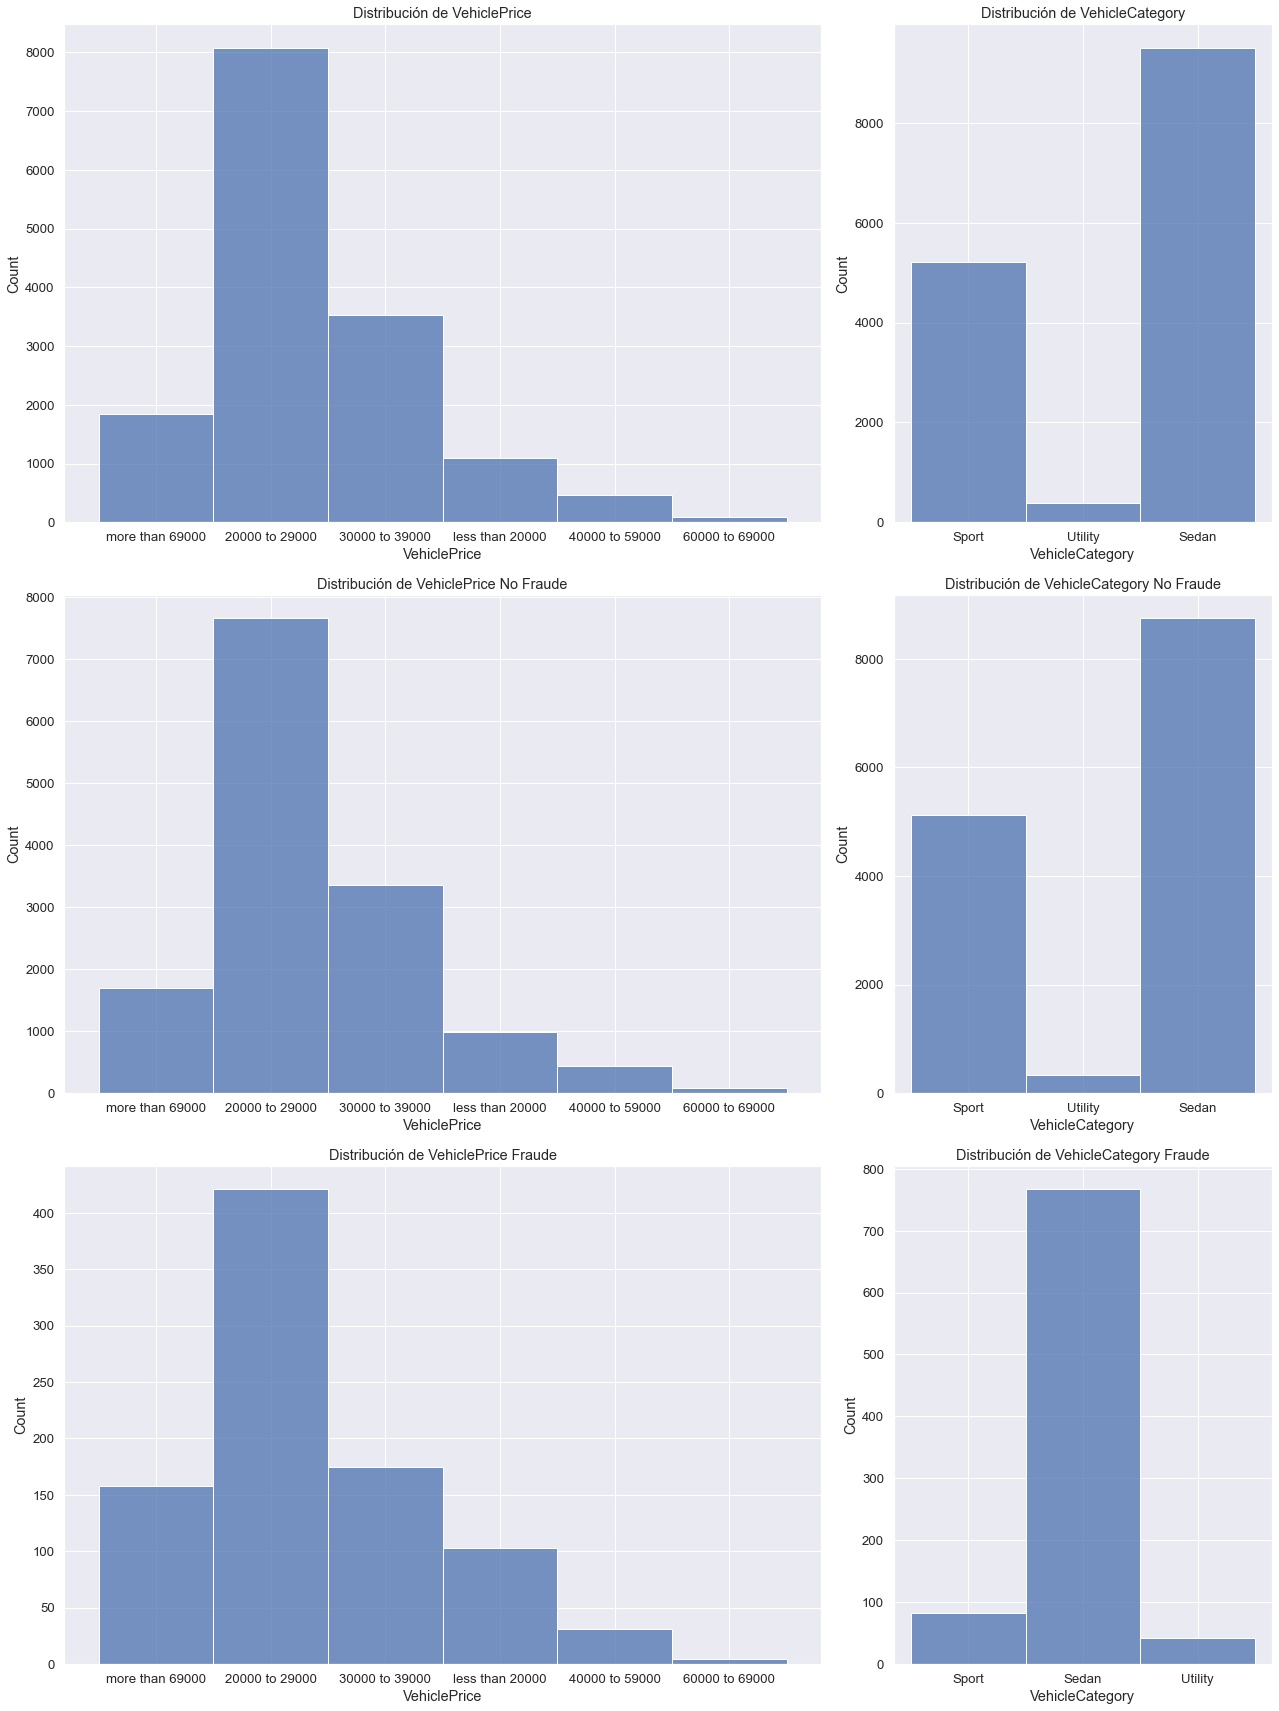

In [14]:
# Crea una figura y subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 24), gridspec_kw={'width_ratios': [2, 1]})

# Histograma para VehiclePrice
sns.histplot(data=df, x='vehicleprice', ax=axes[0][0])
axes[0][0].set_title('Distribución de VehiclePrice')
axes[0][0].set_xlabel('VehiclePrice')
axes[0][0].set_ylabel('Count')

# Histograma para VehicleCategory
sns.histplot(data=df, x='vehiclecategory', ax=axes[0][1])
axes[0][1].set_title('Distribución de VehicleCategory')
axes[0][1].set_xlabel('VehicleCategory')
axes[0][1].set_ylabel('Count')

# Histograma para VehiclePrice
sns.histplot(data=df.loc[df['fraudfound_p'] == 0], x='vehicleprice', ax=axes[1][0])
axes[1][0].set_title('Distribución de VehiclePrice No Fraude')
axes[1][0].set_xlabel('VehiclePrice')
axes[1][0].set_ylabel('Count')

# Histograma para VehicleCategory
sns.histplot(data=df.loc[df['fraudfound_p'] == 0], x='vehiclecategory', ax=axes[1][1])
axes[1][1].set_title('Distribución de VehicleCategory No Fraude')
axes[1][1].set_xlabel('VehicleCategory')
axes[1][1].set_ylabel('Count')

# Histograma para VehiclePrice
sns.histplot(data=df.loc[df['fraudfound_p'] == 1], x='vehicleprice', ax=axes[2][0])
axes[2][0].set_title('Distribución de VehiclePrice Fraude')
axes[2][0].set_xlabel('VehiclePrice')
axes[2][0].set_ylabel('Count')

# Histograma para VehicleCategory
sns.histplot(data=df.loc[df['fraudfound_p'] == 1], x='vehiclecategory', ax=axes[2][1])
axes[2][1].set_title('Distribución de VehicleCategory Fraude')
axes[2][1].set_xlabel('VehicleCategory')
axes[2][1].set_ylabel('Count')

# Ajusta el espaciado entre los subplots
plt.tight_layout()

# Muestra las gráficas
plt.show()

### Al analizar el tipo de vehículo y su precio, variando si era fraude o no el registro, se puede ver que respecto al precio del mismo no hay diferencias grandes, sin embargo, se ve que cuando hay fraude, la gran mayoría de los vehículos involucrados son de tipo sedan.

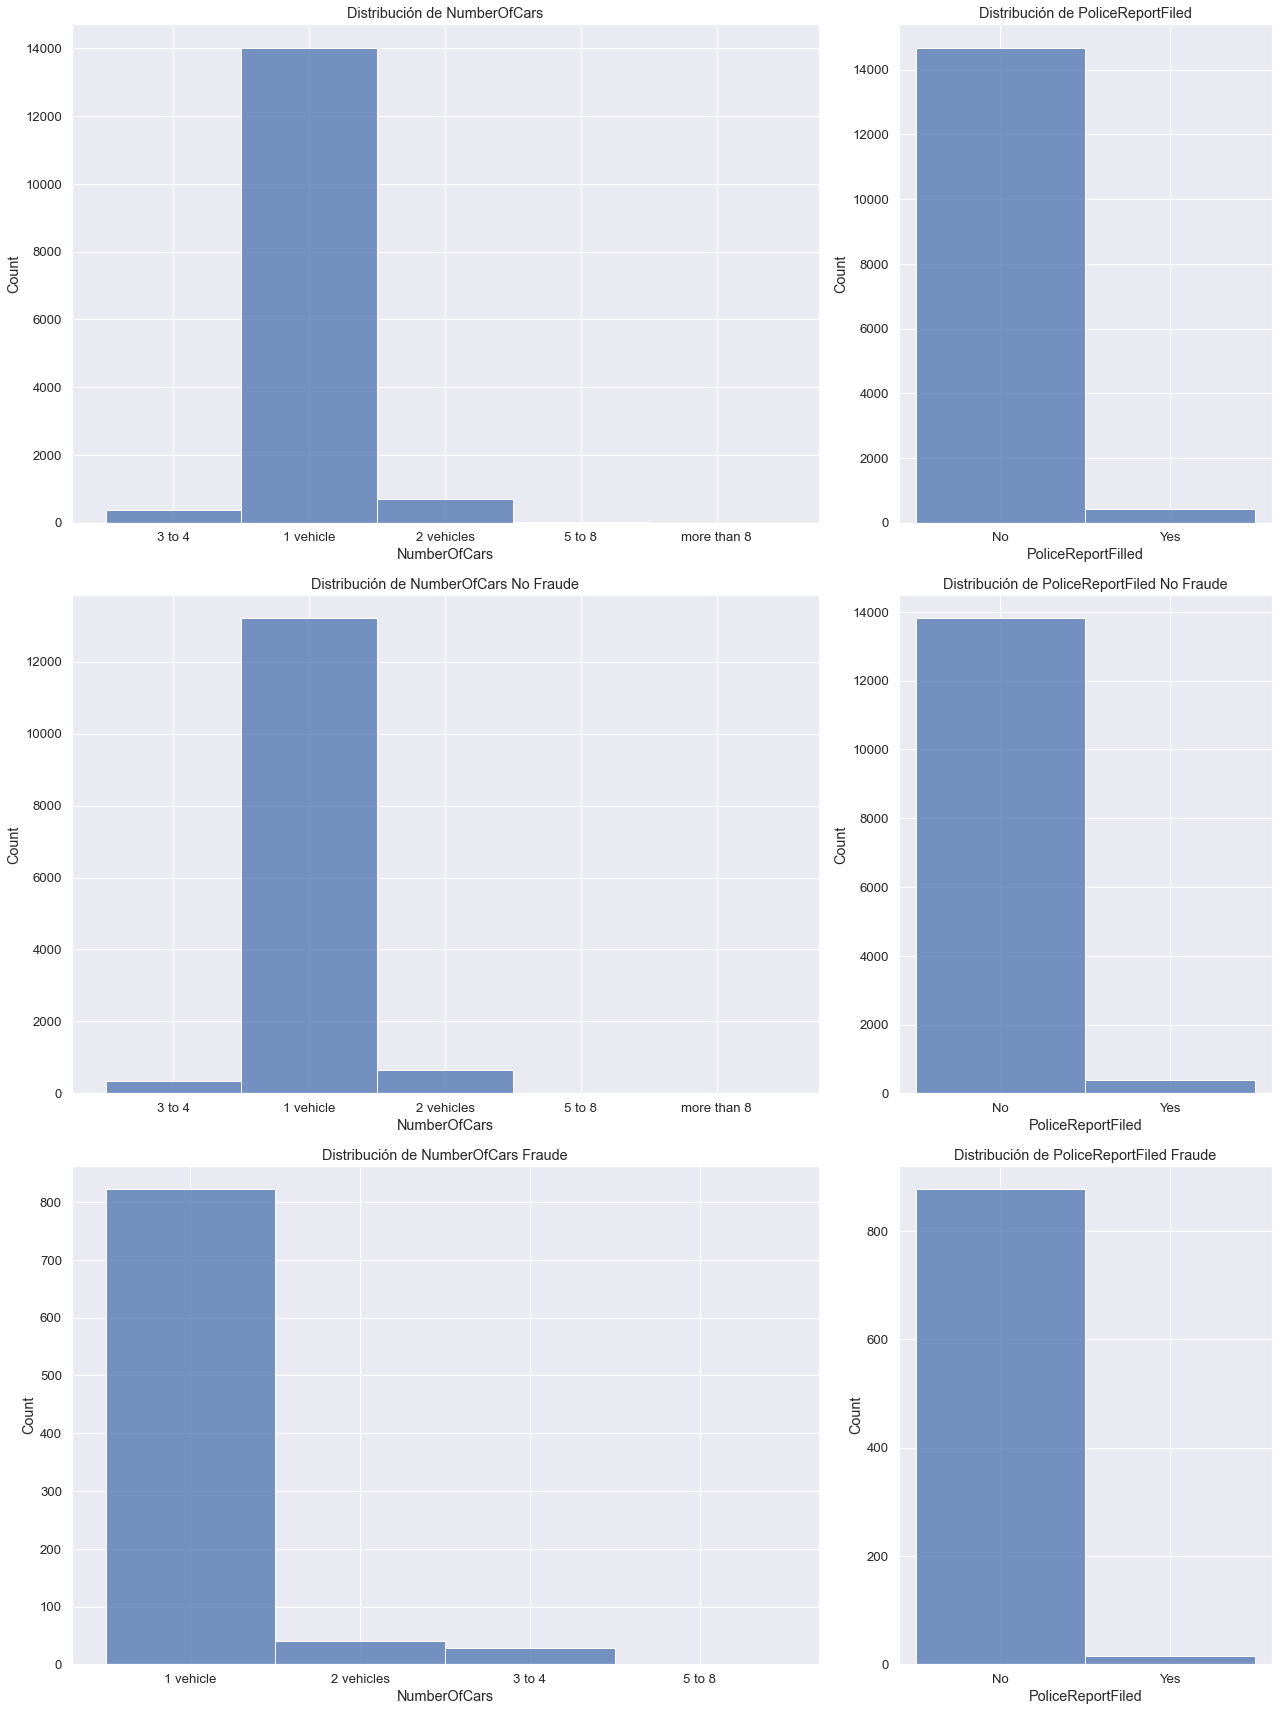

In [15]:

# Crea una figura y subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 24), gridspec_kw={'width_ratios': [2, 1]})

# Histograma para NumberOfCars
sns.histplot(data=df, x='numberofcars', ax=axes[0][0])
axes[0][0].set_title('Distribución de NumberOfCars')
axes[0][0].set_xlabel('NumberOfCars')
axes[0][0].set_ylabel('Count')

# Histograma para PoliceReportFiled
sns.histplot(data=df, x='policereportfiled', ax=axes[0][1])
axes[0][1].set_title('Distribución de PoliceReportFiled')
axes[0][1].set_xlabel('PoliceReportFilled')
axes[0][1].set_ylabel('Count')

# Histograma para NumberOfCars
sns.histplot(data=df.loc[df['fraudfound_p'] == 0], x='numberofcars', ax=axes[1][0])
axes[1][0].set_title('Distribución de NumberOfCars No Fraude')
axes[1][0].set_xlabel('NumberOfCars')
axes[1][0].set_ylabel('Count')

# Histograma para PoliceReportFiled
sns.histplot(data=df.loc[df['fraudfound_p'] == 0], x='policereportfiled', ax=axes[1][1])
axes[1][1].set_title('Distribución de PoliceReportFiled No Fraude')
axes[1][1].set_xlabel('PoliceReportFiled')
axes[1][1].set_ylabel('Count')

# Histograma para NumberOfCars
sns.histplot(data=df.loc[df['fraudfound_p'] == 1], x='numberofcars', ax=axes[2][0])
axes[2][0].set_title('Distribución de NumberOfCars Fraude')
axes[2][0].set_xlabel('NumberOfCars')
axes[2][0].set_ylabel('Count')

# Histograma para PoliceReportFiled
sns.histplot(data=df.loc[df['fraudfound_p'] == 1], x='policereportfiled', ax=axes[2][1])
axes[2][1].set_title('Distribución de PoliceReportFiled Fraude')
axes[2][1].set_xlabel('PoliceReportFiled')
axes[2][1].set_ylabel('Count')

# Ajusta el espaciado entre los subplots
plt.tight_layout()

# Muestra las gráficas
plt.show()

### Los resultados luego de analizar el número de carros involucrados en el accidente y si se lleno un reporte policial parecen no ser concluyentes acerca de si fue fraude o no el registro pues se tienen las mismas distribuciones. Adicionalmente siempre se ve una clase dominante. Para el caso del numero de vehículos predomina "1 vehicle", mientras que para PoliceReportFiled predomina el "No". Esto puede hacer que estas variables no sean del todo relevantes para un modelo.

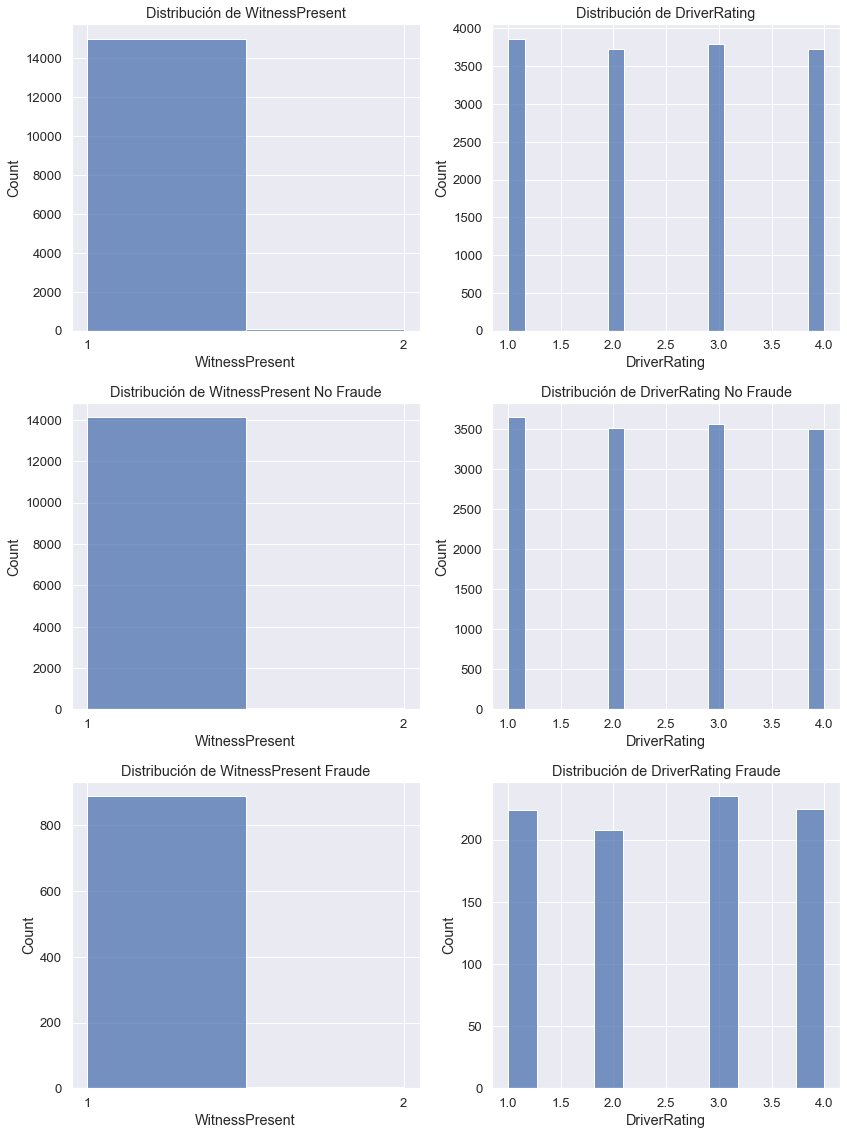

In [16]:

# Crea una figura y subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 16))

# Histograma para WitnessPresent
sns.histplot(data=df, x='witnesspresent', ax=axes[0][0], bins=2)
axes[0][0].set_title('Distribución de WitnessPresent')
axes[0][0].set_xlabel('WitnessPresent')
axes[0][0].set_ylabel('Count')
axes[0][0].set_xticks([1, 2])

# Histograma para DriverRating
sns.histplot(data=df, x='driverrating', ax=axes[0][1])
axes[0][1].set_title('Distribución de DriverRating')
axes[0][1].set_xlabel('DriverRating')
axes[0][1].set_ylabel('Count')


# Histograma para WitnessPresent
sns.histplot(data=df.loc[df['fraudfound_p'] == 0], x='witnesspresent', ax=axes[1][0], bins=2)
axes[1][0].set_title('Distribución de WitnessPresent No Fraude')
axes[1][0].set_xlabel('WitnessPresent')
axes[1][0].set_ylabel('Count')
axes[1][0].set_xticks([1, 2])

# Histograma para DriverRating
sns.histplot(data=df.loc[df['fraudfound_p'] == 0], x='driverrating', ax=axes[1][1])
axes[1][1].set_title('Distribución de DriverRating No Fraude')
axes[1][1].set_xlabel('DriverRating')
axes[1][1].set_ylabel('Count')

# Histograma para WitnessPresent
sns.histplot(data=df.loc[df['fraudfound_p'] == 1], x='witnesspresent', ax=axes[2][0], bins=2)
axes[2][0].set_title('Distribución de WitnessPresent Fraude')
axes[2][0].set_xlabel('WitnessPresent')
axes[2][0].set_ylabel('Count')
axes[2][0].set_xticks([1, 2])

# Histograma para DriverRating
sns.histplot(data=df.loc[df['fraudfound_p'] == 1], x='driverrating', ax=axes[2][1])
axes[2][1].set_title('Distribución de DriverRating Fraude')
axes[2][1].set_xlabel('DriverRating')
axes[2][1].set_ylabel('Count')

# Ajusta el espaciado entre los subplots
plt.tight_layout()

# Muestra las gráficas
plt.show()

### El análisis de WitnessPresent permite observar que no tiene mucha significancia en la definición de fraude o no del suceso, dado que la disitribución está fuertemente inclinada por el no. Esto sugiere que la variable no es buena para predecir un posible fraude. Para el caso de DriverRating, no se ve una tendencia que logre indicar que cierto nivel de habilidad resulte en fraudes o no.

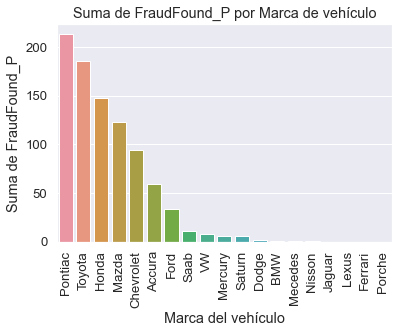

In [22]:
# Calcular la suma de "FraudFound_P" por cada "Make"
df_sum = df.groupby("make")["fraudfound_p"].sum().reset_index()

# Ordenar los datos por la suma de "FraudFound_P" de forma descendente
df_sum_sorted = df_sum.sort_values(by="fraudfound_p", ascending=False)

# Crear el gráfico de barras
sns.barplot(data=df_sum_sorted, x="make", y="fraudfound_p")

# Rotar las etiquetas del eje x para mayor legibilidad
plt.xticks(rotation=90)

# Agregar etiquetas y título
plt.xlabel("Marca del vehículo")
plt.ylabel("Suma de FraudFound_P")
plt.title("Suma de FraudFound_P por Marca de vehículo")

# Mostrar el gráfico
plt.show()

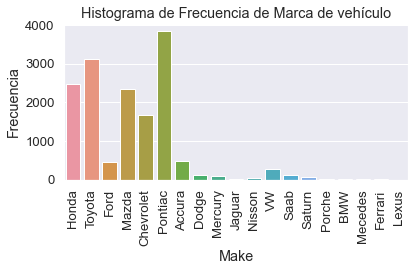

In [24]:
# Crear el histograma de frecuencia
sns.countplot(data=df, x='make')

# Rotar las etiquetas del eje x para mayor legibilidad
plt.xticks(rotation=90)

# Agregar etiquetas y título
plt.xlabel('Make')
plt.ylabel('Frecuencia')
plt.title('Histograma de Frecuencia de Marca de vehículo')

# Ajustar el tamaño de la figura para evitar superposición de etiquetas
plt.tight_layout()

# Mostrar el histograma
plt.show()

### Se ve que aunque la mayoría de reportes fraudulentos son hechos por ciertas marcas de vehículo, esto se debe a una predominancia de dichas marcas en el conjunto de datos.

In [27]:
##Eliminación de columna witness present
df = df.drop('witnesspresent', axis=1)

In [28]:
##Aplicación de regresión logística

# Codificar variables categóricas utilizando one-hot encoding
df_encoded = pd.get_dummies(df, columns=['monthh', 'make', 'dayofweekclaimed', 'monthclaimed', 'maritalstatus', 'fault', 'policytype', 'vehiclecategory', 'vehicleprice', 'days_policy_accident', 'days_policy_claim', 'pastnumberofclaims', 'ageofvehicle', 'ageofpolicyholder', 'policereportfiled', 'agenttype', 'numberofsuppliments', 'addresschange_claim', 'numberofcars', 'basepolicy'])


# Dividir el conjunto de datos en características (X) y variable objetivo (y)
X = df_encoded.drop('fraudfound_p', axis=1)
y = df_encoded['fraudfound_p']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo Random Forest
model = RandomForestClassifier()

# Ajustar el modelo a los datos de entrenamiento
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Evaluar el modelo
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2839
           1       1.00      0.01      0.02       181

    accuracy                           0.94      3020
   macro avg       0.97      0.51      0.50      3020
weighted avg       0.94      0.94      0.91      3020



True Negatives (TN): 2839
False Positives (FP): 0
False Negatives (FN): 179
True Positives (TP): 2


C:\Users\User\AppData\Local\Temp\ipykernel_24924\1055717030.py:24: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = ax.figure.colorbar(im, ax=ax)


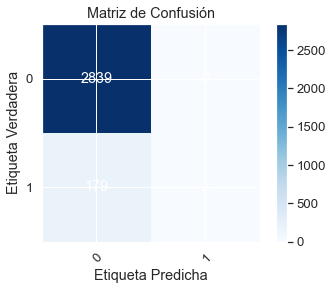

In [32]:
#Confusion matrix

y_pred = model.predict(X_test)
y_true = y_test


cm = confusion_matrix(y_true, y_pred)


tn, fp, fn, tp = cm.ravel()


print("True Negatives (TN):", tn)
print("False Positives (FP):", fp)
print("False Negatives (FN):", fn)
print("True Positives (TP):", tp)

# Define las etiquetas de las clases
labels = np.unique(y_true)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
# Añade una barra de color para representar los valores
cbar = ax.figure.colorbar(im, ax=ax)

# Añade las etiquetas de las clases
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Rota las etiquetas del eje x para una mejor legibilidad
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Añade los valores en cada celda
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="white")

# Añade etiquetas de ejes y un título
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Verdadera")
plt.title("Matriz de Confusión")

# Muestra la matriz de confusión
plt.show()


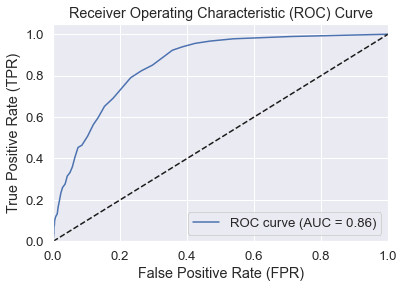

In [94]:
#ROC
y_pred_probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.show()

### Como se puede ver en la matriz de confusión, los resultados del modelo se ven fuertemente afectados por el gran desbalance en las clases que hay. Esto lo indica la baja tasa de True Positives, ya que no hay muchos datos que se hayan categorizado como fraude, esto hace que el modelo no pueda aprender correctamente y por consiguiente, no tendrá un buen desempeño.

In [98]:
#Aplicación de SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Create the Random Forest classifier
model = RandomForestClassifier()

# Fit the model to the resampled data
model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

y_pred = model.predict(X_test)
y_true = y_test


cm = confusion_matrix(y_true, y_pred)


tn, fp, fn, tp = cm.ravel()


print("True Negatives (TN):", tn)
print("False Positives (FP):", fp)
print("False Negatives (FN):", fn)
print("True Positives (TP):", tp)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2903
           1       0.60      0.02      0.03       181

    accuracy                           0.94      3084
   macro avg       0.77      0.51      0.50      3084
weighted avg       0.92      0.94      0.91      3084

True Negatives (TN): 2901
False Positives (FP): 2
False Negatives (FN): 178
True Positives (TP): 3


## La conclusión más grande de este desarrollo es que para predecir el fraude de una manera adecuada es necesario

In [ ]:
cur.close()
conn.close()